# Notebook Imports


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [4]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TESTING_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

# Reading Files

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [6]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [7]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
        
    elif line == '\n':
        is_body = True

stream.close()

email_body = ''.join(lines)
print(email_body)



Dear Mr Still

Good tidings to you and all your staff for the festive season ahead (Christmas).
Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.
But WAIT! You're probably thinking: "What makes him so special?"
Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.
You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.
I look forward to hearing from you.

Best wishes
Robin Cooper
[Excerpt from the book: The Timewaster Letters by Robi

# Generator Functions

In [8]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [9]:
for i in generate_squares(3):
    print(i, end=' ->')

0 ->1 ->4 ->

# Email Body Extraction

In [10]:
def email_body_generator(path):
    
    for root, dirnames, filenames in os.walk(path):
        
        for filename in filenames:
            
            filepath = os.path.join(root, filename)   
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)

                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = ''.join(lines)
            
            yield filename, email_body

In [11]:
def df_from_directory(path, classification):
    
    rows = []
    row_names = []
    
    for filename, email_body in email_body_generator(path):
        
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(filename)
        
    return pd.DataFrame(rows, index=row_names)

In [12]:
spam_emails = df_from_directory(path=SPAM1_PATH, classification=SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM2_PATH, SPAM_CAT))
spam_emails.head()

,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n1) Slim Down ...


In [13]:
spam_emails.shape

(1898, 2)

In [14]:
non_spam_emails = df_from_directory(path=EASY_NONSPAM1_PATH, classification=HAM_CAT)
non_spam_emails = non_spam_emails.append(df_from_directory(path=EASY_NONSPAM2_PATH, classification=HAM_CAT))
non_spam_emails.head()

,CATEGORY,MESSAGE
00001.7c53336b37003a9286aba55d2945844c,0,"Date: Wed, 21 Aug 2002 10:54:46 -05..."
00002.9c4069e25e1ef370c078db7ee85ff9ac,0,"Martin A posted:\nTassos Papadopoulos, the Gre..."
00003.860e3c3cee1b42ead714c5c874fe25f7,0,Man Threatens Explosion In Moscow \n\nThursday...
00004.864220c5b6930b209cc287c361c99af1,0,Klez: The Virus That Won't Die\n \nAlready the...
00005.bf27cdeaf0b8c4647ecd61b1d09da613,0,"> in adding cream to spaghetti carbonara, whi..."


In [15]:
non_spam_emails.shape

(3901, 2)

In [16]:
data = pd.concat([spam_emails, non_spam_emails])
print('Shape of entite dataframe is ', data.shape)
data.head()

Shape of entite dataframe is  (5799, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n1) Slim Down ...


In [17]:
data.tail()

,CATEGORY,MESSAGE
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\nNow this is probably of no use to..."


# Data Cleaning: Checking For Missing Values

In [18]:
# check if any message body are null

data.MESSAGE.isnull().values.any()

False

In [19]:
my_var = None

In [20]:
# check if there are empty emails(string length zero)

(data.MESSAGE.str.len() == 0).any()

True

In [21]:
(data.MESSAGE.str.len() == 0).sum()

3

In [22]:
# checking num values

data.MESSAGE.isnull().sum()

0

# Locate Empty Emails

In [23]:
 type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [24]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove System File Entries From Dataframe

In [25]:
# data.drop(['cmds'], inplace=True)

In [26]:
data.shape

(5799, 2)

# Add Document IDs To Track Emails In Dataset

In [27]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [28]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n1) Slim Down ...,00005.57696a39d7d84318ce497886896bf90d


In [29]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5794,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5795,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5796,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5797,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5798,0,"Hi there,\n\nNow this is probably of no use to...",01400.f897f0931e461e7b2e964d28e927c35e


# Save To File Using Pandas

In [30]:
data.to_json(DATA_JSON_FILE)

# Number Of Spam Messages Visualized (Pie Charts)

In [31]:
data.CATEGORY.value_counts()

0    3901
1    1898
Name: CATEGORY, dtype: int64

In [32]:
spam_amount = data.CATEGORY.value_counts()[1]
nonspam_amount = data.CATEGORY.value_counts()[0]

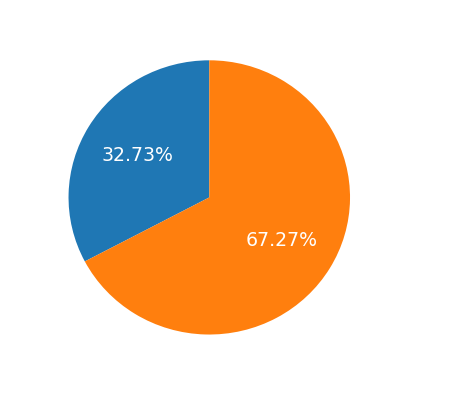

In [33]:
category_names = ['Spam', 'Legit Mail']
sizes = [spam_amount, nonspam_amount]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6, 'color': 'white'},
        startangle=90, autopct='%1.2f%%')
plt.show()

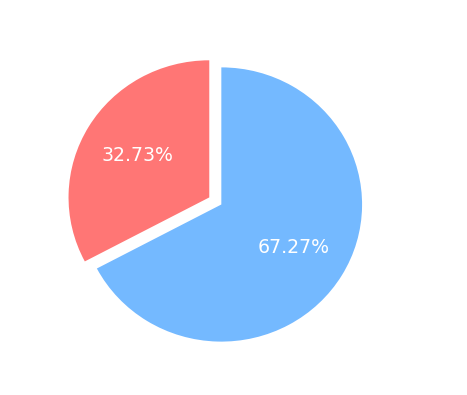

In [34]:
category_names = ['Spam', 'Legit Mail']
sizes = [spam_amount, nonspam_amount]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6, 'color': 'white'},
        startangle=90, autopct='%1.2f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

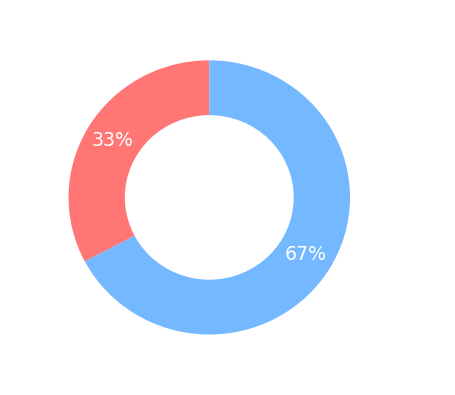

In [35]:
category_names = ['Spam', 'Legit Mail']
sizes = [spam_amount, nonspam_amount]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6, 'color': 'white'},
        startangle=90, colors=custom_colours, autopct='%1.0f%%', pctdistance=0.8)

# draw circle 
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

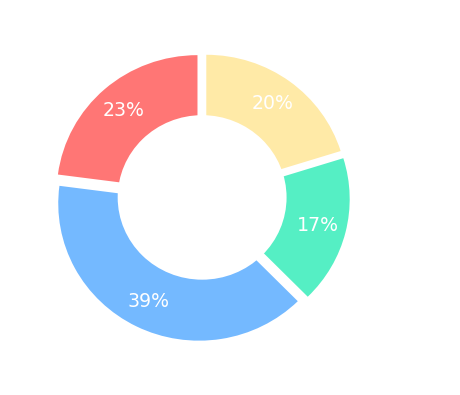

In [36]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6, 'color': 'white'},
        startangle=90, colors=custom_colours, autopct='%1.0f%%', pctdistance=0.8, explode=offset)

# draw circle 
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre Processing

### Download the NLTK Resources(Tokenizer and Stopwords)

In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\samee\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\samee\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

# Tokenising

In [40]:
msg = 'All that glitters is not gold.'
word_tokenize(msg.lower())

['all', 'that', 'glitters', 'is', 'not', 'gold', '.']

## Removing Stop Words

In [41]:
stop_words = set(stopwords.words('english'))

In [42]:
type(stop_words)

set

In [43]:
if 'this' in stop_words:
    print('Found')

Found


In [44]:
if 'hello' in stop_words:
    print('Found')
else:
    print('Not Found')

Not Found


In [45]:
if 'hello' not in stop_words:
    print('Not Found')

Not Found


In [46]:
msg = 'All that glitters is not gold.'
words = word_tokenize(msg.lower())
print(words)

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
print(filtered_words)

['all', 'that', 'glitters', 'is', 'not', 'gold', '.']
['glitters', 'gold', '.']


## Word Stems And Stemming

In [47]:
msg = 'All that glitters is not gold. \
        Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())
print(words)

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)

['all', 'that', 'glitters', 'is', 'not', 'gold', '.', 'nobody', 'expects', 'the', 'spanish', 'inquisition', '!']
['glitter', 'gold', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [48]:
'p'.isalpha()

True

In [49]:
'?'.isalpha()

False

In [50]:
msg = 'All that glitters is not gold. \
        Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())
print(words)

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
print(filtered_words)


['all', 'that', 'glitters', 'is', 'not', 'gold', '.', 'nobody', 'expects', 'the', 'spanish', 'inquisition', '!']
['glitter', 'gold', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from emails

In [51]:
soup = BeautifulSoup(data.at[202, 'MESSAGE'], 'html.parser')
soup.prettify()

'This is a multi-part message in MIME format.\n\n------=_NextPart_000_14AAA3_01C251CD.D3972A00\nContent-Type: text/plain;\n\tcharset="Windows-1252"\nContent-Transfer-Encoding: 7bit\n\n We\'ll help you find and fund LTC alternatives!\t \t\n M&amp;O Marketing -- The Agent\'s Company\t\n Place your LTC declines!\t\n\nAlzheimer\'s. Heart attacks. Diabetes. Parkinson\'s.\nYou can offer guaranteed issue disability benefits to these clients \nwith tax advantages and no underwriting!\n\nWe\'ll help you find?and fund?long term care alternatives for your\nclients. \nYou can make an additional, up-front commission and a bonus\nalong with the Long Term Care sales you\'re making!\n\nAsk us for the LTC Alternatives. We\'ll give you multiple carriers and\noptions for your clients.\n 800-862-9133\n? or ? \nPlease fill out the form below for more information\t \nName:\t  \t \t\nE-mail:\t  \t\nPhone:\t  \t\nCity:\t  \tState:\t  \t\n \t  \t \t   \t\n \n \nFor agent use only. \nWe don\'t want anyone to re

In [52]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n------=_NextPart_000_14AAA3_01C251CD.D3972A00\nContent-Type: text/plain;\n\tcharset="Windows-1252"\nContent-Transfer-Encoding: 7bit\n\n We\'ll help you find and fund LTC alternatives!\t \t\n M&O Marketing -- The Agent\'s Company\t\n Place your LTC declines!\t\n\nAlzheimer\'s. Heart attacks. Diabetes. Parkinson\'s.\nYou can offer guaranteed issue disability benefits to these clients \nwith tax advantages and no underwriting!\n\nWe\'ll help you find?and fund?long term care alternatives for your\nclients. \nYou can make an additional, up-front commission and a bonus\nalong with the Long Term Care sales you\'re making!\n\nAsk us for the LTC Alternatives. We\'ll give you multiple carriers and\noptions for your clients.\n 800-862-9133\n? or ? \nPlease fill out the form below for more information\t \nName:\t  \t \t\nE-mail:\t  \t\nPhone:\t  \t\nCity:\t  \tState:\t  \t\n \t  \t \t   \t\n \n \nFor agent use only. \nWe don\'t want anyone to receiv

## Functions For Email Processing 

In [53]:
def clean_message_no_html(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    filtered_words = []
    
    for word in words:
        # Removes stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [54]:
clean_message_no_html(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [55]:
clean_message_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

## Apply Cleaning And Tokenising to all messages

# Slicing Dataframes and series and creating subsets

In [56]:
data.iat[2, 2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [57]:
data.iloc[0:2]

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,00002.d94f1b97e48ed3b553b3508d116e6a09


In [58]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message_no_html)
type(first_emails.apply(clean_message_no_html))

pandas.core.series.Series

In [59]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
#         print(item)

flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

192

In [60]:
flat_list

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email',
 'fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'ch

In [61]:
%%time 

# use apply() on all messages in the dataframe 

nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\samee\anc\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 42 s


In [62]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [63]:
nested_list.tail()

DOC_ID
5794    [http, bizarr, collect, stuf, anim, could, fet...
5795    [care, use, one, also, realli, cute, thing, ja...
5796    [sm, skip, montanaro, write, jeremi, put, anot...
5797    [mark, hammond, like, given, zodb, sound, attr...
5798    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using Logic to Slice Dataframes

In [64]:
data[data.CATEGORY == 0].shape

(3901, 3)

In [65]:
data[data.CATEGORY == 1].tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
1893,1,This is a multi-part message in MIME format.\n...,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1894,1,"Dear Subscriber,\n\nIf I could show you a way ...",01398.8ca7045aae4184d56e8509dc5ad6d979
1895,1,****Mid-Summer Customer Appreciation SALE!****...,01399.2319643317e2c5193d574e40a71809c2
1896,1,ATTN:SIR/MADAN \n\n ...,01400.b444b69845db2fa0a4693ca04e6ac5c5
1897,1,,cmds


In [66]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [67]:
doc_ids_ham

Int64Index([1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907,
            ...
            5789, 5790, 5791, 5792, 5793, 5794, 5795, 5796, 5797, 5798],
           dtype='int64', name='DOC_ID', length=3901)

 ## Susetting a Series with an index

In [68]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [69]:
type(nested_list)

pandas.core.series.Series

In [70]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [71]:
nested_list_ham.shape

(3901,)

In [72]:
nested_list_ham.tail()

DOC_ID
5794    [http, bizarr, collect, stuf, anim, could, fet...
5795    [care, use, one, also, realli, cute, thing, ja...
5796    [sm, skip, montanaro, write, jeremi, put, anot...
5797    [mark, hammond, like, given, zodb, sound, attr...
5798    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

In [73]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [74]:
nested_list_ham

DOC_ID
1898    [date, wed, aug, chri, garrigu, ca, reproduc, ...
1899    [martin, post, tasso, papadopoulo, greek, scul...
1900    [man, threaten, explos, moscow, thursday, augu...
1901    [klez, viru, wo, die, alreadi, prolif, viru, e...
1902    [ad, cream, spaghetti, carbonara, effect, past...
1903    [jump, carbonara, one, favourit, make, ask, he...
1904    [scotsman, august, playboy, want, go, bang, ag...
1905    [martin, adamson, wrote, basic, mixtur, beaten...
1906    [scotsman, thu, aug, meaning, sentenc, tracey,...
1907    [tri, research, via, sa, mirror, search, engin...
1908    [hello, seen, discuss, articl, approach, thank...
1909    [ye, great, mind, think, alik, even, withput, ...
1910    [mon, aug, john, looney, mention, like, get, b...
1911    [chri, garrigu, date, wed, aug, chri, garrigu,...
1912    [spamassassin, hurt, democraci, owen, http, in...
1913    [hi, apolog, possibl, silli, question, think, ...
1914    [forteana, wrote, robert, moabi, sent, death, ...
1915   

In [75]:
# word_length = 0

# for item in nested_list_ham:
#     item_length = len(item)
#     word_length += item_length

# print(counter)

flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0]

20751

In [76]:
normal_words[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

In [77]:
# length = 0

# for item in nested_list_spam:
#     item_length = len(item)
#     length += item_length

# print(length)

flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()

spammy_words.shape[0]

13282

In [78]:
spammy_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

## Creating A Word Cloud

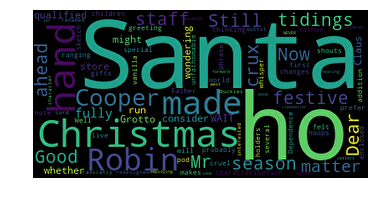

In [79]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='sinc')
plt.axis('off')
plt.show()

In [80]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [81]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [82]:
word_list = [''.join(word) for word in example_corpus]
# word_list
novel_as_str = ''.join(word_list)

In [83]:
novel_as_str

'[MobyDickbyHermanMelville1851]ETYMOLOGY.(SuppliedbyaLateConsumptiveUshertoaGrammarSchool)ThepaleUsher--threadbareincoat,heart,body,andbrain;Iseehimnow.Hewaseverdustinghisoldlexiconsandgrammars,withaqueerhandkerchief,mockinglyembellishedwithallthegayflagsofalltheknownnationsoftheworld.Helovedtodusthisoldgrammars;itsomehowmildlyremindedhimofhismortality."Whileyoutakeinhandtoschoolothers,andtoteachthembywhatnameawhale-fishistobecalledinourtongueleavingout,throughignorance,theletterH,whichalmostalonemakeththesignificationoftheword,youdeliverthatwhichisnottrue."--HACKLUYT"WHALE....Sw.andDan.HVAL.Thisanimalisnamedfromroundnessorrolling;forinDan.HVALTisarchedorvaulted."--WEBSTER\'SDICTIONARY"WHALE....ItismoreimmediatelyfromtheDut.andGer.WALLEN;A.S.WALW-IAN,toroll,towallow."--RICHARDSON\'SDICTIONARYKETOS,GREEK.CETUS,LATIN.WHOEL,ANGLO-SAXON.HVALT,DANISH.WAL,DUTCH.HWAL,SWEDISH.WHALE,ICELANDIC.WHALE,ENGLISH.BALEINE,FRENCH.BALLENA,SPANISH.PEKEE-NUEE-NUEE,FEGEE.PEKEE-NUEE-NUEE,ERROMANGOAN.EXTRACTS

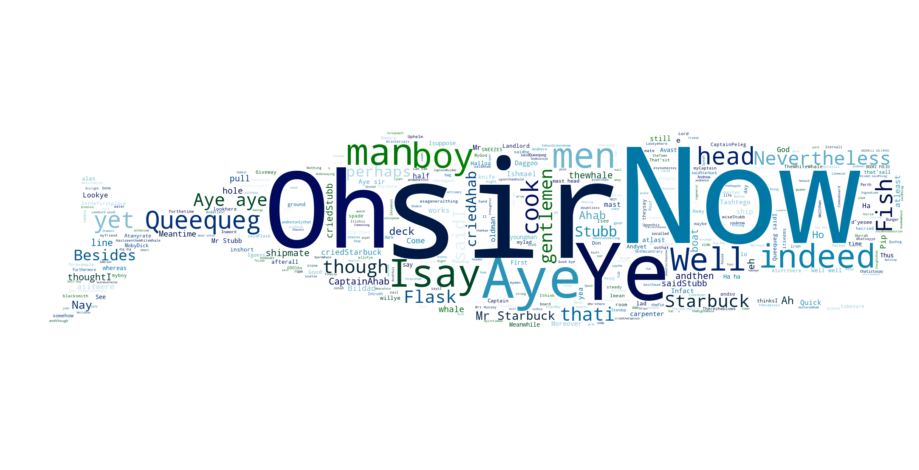

In [84]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white',max_words=400, colormap='ocean')
word_cloud.generate(novel_as_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [85]:
rgb_array.shape

(1024, 2048, 3)

In [86]:
rgb_array[1023, 2046]

array([255, 255, 255], dtype=uint8)

In [87]:
rgb_array[523, 1000]

array([0, 0, 0], dtype=uint8)

## Shakespeare Hamlet

In [88]:
ex_file = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
len(ex_file)
type(ex_file)

nltk.corpus.reader.util.StreamBackedCorpusView

In [89]:
ex_list = [''.join(word) for word in ex_file]
# word_list
novel_ex = ''.join(ex_file)

In [90]:
novel_ex

"[TheTragedieofHamletbyWilliamShakespeare1599]ActusPrimus.ScoenaPrima.EnterBarnardoandFranciscotwoCentinels.Barnardo.Who'sthere?Fran.Nayanswerme:Stand&vnfoldyourselfeBar.LongliuetheKingFran.Barnardo?Bar.HeFran.YoucomemostcarefullyvponyourhoureBar.'Tisnowstrooktwelue,gettheetobedFranciscoFran.Forthisreleefemuchthankes:'Tisbittercold,AndIamsickeatheartBarn.HaueyouhadquietGuard?Fran.NotaMousestirringBarn.Well,goodnight.IfyoudomeetHoratioandMarcellus,theRiualsofmyWatch,bidthemmakehast.EnterHoratioandMarcellus.Fran.IthinkeIhearethem.Stand:who'sthere?Hor.FriendstothisgroundMar.AndLeige-mentotheDaneFran.GiueyougoodnightMar.OfarwelhonestSoldier,whohathrelieu'dyou?Fra.Barnardoha'smyplace:giueyougoodnight.ExitFran.Mar.HollaBarnardoBar.Say,whatisHoratiothere?Hor.ApeeceofhimBar.WelcomeHoratio,welcomegoodMarcellusMar.What,ha'sthisthingappear'dagainetonightBar.IhaueseenenothingMar.Horatiosaies,'tisbutourFantasie,AndwillnotletbeleefetakeholdofhimTouchingthisdreadedsight,twiceseeneofvs,ThereforeIhauei

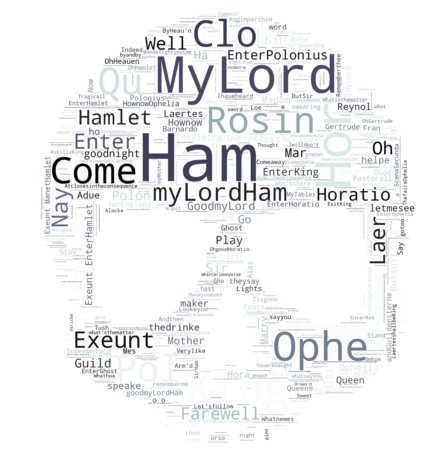

In [91]:
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) #converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white',max_words=600, colormap='bone')
word_cloud.generate(novel_ex)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud Of Ham And Spam Messages 

In [92]:
# icon = Image.open(THUMBS_UP_FILE)
# image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
# image_mask.paste(icon, box=icon)

# rgb_array = np.array(image_mask) #converts the image object to an array

# # Generate text as a string for the word cloud

# spam_str = ''.join(flat_list_spam)

# word_cloud = WordCloud(mask=rgb_array, background_color='white',max_words=40, colormap='ocean')
# word_cloud.generate(spam_str)

# plt.figure(figsize=[16, 8])
# plt.imshow(word_cloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

## Generate Vocabulary And Dictionary

In [93]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\samee\anc\lib\site-packages\bs4\__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [94]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('No of unique words:', unique_words.shape[0])
unique_words.head()

No of unique words: 27302


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [95]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


In [96]:
type(frequent_words)

pandas.core.series.Series

## Create Vocabulary DataFrame with a WORD_ID

In [97]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [98]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Checking If A Word Is Part Of A Vocabulary

In [99]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [100]:
'data' in set(vocab.VOCAB_WORD) # efficient

True

## Find the Email with the Most Number Of Words

In [101]:
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [102]:
print(clean_email_lengths)

[92, 56, 44, 205, 45, 161, 47, 162, 202, 43, 55, 23, 44, 73, 58, 235, 47, 208, 36, 56, 223, 192, 0, 93, 14, 208, 44, 24, 61, 94, 312, 56, 141, 72, 55, 1060, 46, 139, 2, 90, 78, 4, 47, 70, 44, 74, 38, 12, 38, 60, 47, 51, 71, 80, 25, 273, 36, 60, 19, 18, 14, 40, 57, 18, 77, 28, 102, 40, 226, 68, 120, 5, 52, 0, 40, 40, 208, 0, 40, 146, 62, 114, 58, 253, 1216, 49, 0, 65, 52, 141, 15, 0, 90, 70, 2, 196, 50, 50, 50, 213, 117, 43, 80, 43, 319, 242, 9, 36, 97, 25, 52, 333, 47, 60, 0, 38, 78, 97, 79, 55, 102, 34, 70, 55, 24, 129, 50, 0, 39, 74, 43, 72, 47, 157, 0, 27, 223, 97, 0, 58, 84, 213, 75, 47, 18, 166, 20, 112, 104, 187, 6, 40, 54, 79, 276, 110, 208, 6, 479, 62, 17, 175, 79, 47, 74, 80, 258, 33, 218, 38, 36, 110, 93, 61, 55, 41, 108, 80, 84, 0, 52, 1389, 108, 97, 23, 185, 1, 117, 258, 28, 142, 195, 177, 0, 97, 109, 1465, 0, 108, 150, 113, 38, 153, 38, 42, 0, 0, 383, 185, 77, 330, 14, 92, 92, 166, 372, 187, 241, 143, 254, 14, 97, 135, 223, 65, 90, 226, 217, 129, 38, 94, 204, 258, 215, 146

In [103]:
# Python List Comprehension
clean_em_lengths = [len(sublist) for sublist in stemmed_nested_list]  
print('No of words in the largest email: ', max(clean_em_lengths))

No of words in the largest email:  7665


In [104]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 5778


In [105]:
stemmed_nested_list[np.argmax(clean_em_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [106]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n4 DVDs Free +s&p Join Now\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n---------------------------------------------------------------------~->\n\nA new version of unison is now available for testing.  It incorporates\nseveral small improvements over 2.9.1, but the main change is a fix to\na bug that had potentially serious safety consequences, but only for\nthe very small number of users that are in the habit of running more\nthan one instance of Unison at a time, in parallel.  These users are\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\nThe release includes pre-built executables for Linux and Solaris, but\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\nthe moment, none of the active developers are regularly using Unison\non Windows, and we do not have a machine that is configured properly\nfor building executables for export.)\n\nGrab it from here:\n   

## Generate Features And a Sparse Matrix


### Creating a DataFrame with one word per Column

In [107]:
type(stemmed_nested_list)

pandas.core.series.Series

In [108]:
type(stemmed_nested_list.tolist())

list

In [109]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [110]:
word_columns_df.shape

(5799, 7665)

## Splitting The Data into a Training and Testing Dataset

In [111]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df,data.CATEGORY, test_size=0.3,
                                                   random_state=42)

In [112]:
print('Number of training samples', X_train.shape[0])
print('Fraction of training', X_train.shape[0] / word_columns_df.shape[0])

Number of training samples 4059
Fraction of training 0.6999482669425763


In [113]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4100,url,http,date,suppli,key,encod,photon,light,sent,kilometr,...,None,None,None,None,None,None,None,None,None,None
5233,dave,long,write,also,strike,long,livestock,genet,engin,dumber,...,None,None,None,None,None,None,None,None,None,None
5072,thu,jul,matthia,saou,wrote,upon,time,matthia,wrote,subject,...,None,None,None,None,None,None,None,None,None,None
1293,creditfix,access,clear,bad,credit,onlin,directli,convieni,watch,credit,...,None,None,None,None,None,None,None,None,None,None
4357,us,lister,recognis,damian,lewi,winter,band,brother,annoy,one,...,None,None,None,None,None,None,None,None,None,None


In [114]:
y_train.head()

DOC_ID
4100    0
5233    0
5072    0
1293    1
4357    0
Name: CATEGORY, dtype: int64

# Create a Sparse Matrix for the Training data

In [115]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [116]:
word_index.get_loc('thu')

395

In [117]:
def make_sparse_matrix(df, indexed_words, labels):
    
    """
    Returns sparse matrix as a dataframe. 
    
    df: A dataframe with words in the columns with a document id as an index(X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    
    """
    no_rows = df.shape[0]
    no_columns = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(no_rows):
        for j in range(no_columns):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [118]:
%%time 
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

Wall time: 3min 42s


In [119]:
sparse_train_df[:5]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4100,0,1,109
1,4100,0,1,0
2,4100,0,1,76
3,4100,0,1,341
4,4100,0,1,383


In [120]:
sparse_train_df.shape

(448976, 4)

In [121]:
sparse_train_df[-5:]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
448971,860,1,1,194
448972,860,1,1,573
448973,860,1,1,18
448974,860,1,1,221
448975,860,1,1,0


## Combine Occurences with the pandas groupby() Method

In [122]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [123]:
vocab.at[3, 'VOCAB_WORD']

'email'

In [124]:
data.MESSAGE[3]

"##################################################\n#                                                #\n#                 Adult Club                     #\n#           Offers FREE Membership               #\n#                                                #\n##################################################\n\n>>>>>  INSTANT ACCESS TO ALL SITES NOW\n>>>>>  Your User Name And Password is.\n>>>>>  User Name: zzzz@spamassassin.taint.org\n>>>>>  Password: 760382\n\n5 of the Best Adult Sites on the Internet for FREE!\n---------------------------------------\nNEWS 08/18/02\nWith just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New\nMembers. Are you one of them yet???\n---------------------------------------\nOur Membership FAQ\n\nQ. Why are you offering free access to 5 adult membership sites for free?\nA. I have advertisers that pay me for ad space so you don't have to pay for membership.\n\nQ. Is it true my membership is for life?\nA. Absolutely you'l

In [125]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [126]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
263489,5798,2061,0,2
263490,5798,2062,0,1
263491,5798,2291,0,1
263492,5798,2364,0,1
263493,5798,2417,0,1


In [127]:
vocab.at[2060, 'VOCAB_WORD']

'own'

In [128]:
data.MESSAGE[5798]

"Hi there,\n\nNow this is probably of no use to you whatsoever, but...\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\npretty much the same hardware. \nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\nboth use the same driver module. \n\nBoth have same kernel version albeit it compiled for their particular\nhardware.\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\nsee the NVdriver is loaded, but not used ;--(\nThus when I startx, it bombs out. \n\nIU still have X with the default nv driver and crappy accelleration -->\n650fps with glxgears [should be over 2000fps]\nIts not a hardware issue with the cards as I swapped them over and get the\nsame symptoms. \n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\nresources etc all to no avail. \nShould there be an interrupt for the nv card? I haven't checked the other\nbox yet.\n\nRegards,\nCW\n\n-------------------\nOn Tue, 03 Dec

In [129]:
train_grouped.shape

(263494, 4)

## Save Training Data as .txt File

In [130]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [131]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [132]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7655,7656,7657,7658,7659,7660,7661,7662,7663,7664
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4925,thu,jul,chad,norwood,wrote,steven,champeon,wrote,chad,progress,...,None,None,None,None,None,None,None,None,None,None
1103,webcredit,thank,email,address,obtain,ase,list,refer,wish,unsubscrib,...,None,None,None,None,None,None,None,None,None,None
812,hello,jm,growth,hormon,therapi,lose,weight,build,lean,muscl,...,None,None,None,None,None,None,None,None,None,None
1632,applic,grant,rememb,type,grant,never,need,repay,time,limit,...,None,None,None,None,None,None,None,None,None,None
1128,hey,like,tri,everyth,lose,weight,know,feel,special,diet,...,None,None,None,None,None,None,None,None,None,None


In [133]:
%%time 
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

Wall time: 1min 37s


In [134]:
sparse_test_df.head()

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4925,0,1,395
1,4925,0,1,494
2,4925,0,1,37
3,4925,0,1,37
4,4925,0,1,1127


In [135]:
sparse_test_df.shape

(185093, 4)

In [136]:
tested_group = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()

In [137]:
tested_group.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [138]:
tested_group.shape

(112511, 4)

In [139]:
np.savetxt(TESTING_DATA_FILE, tested_group, fmt='%d')

# Pre Processing Subtleties

## Checking how many emails were included in the testing.txt 

In [142]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(tested_group.DOC_ID)

In [143]:
len(train_doc_ids)

4014

In [144]:
len(test_doc_ids)

1725

In [145]:
len(X_test)

1740

In [148]:
set(X_test.index.values) - test_doc_ids

{134,
 179,
 240,
 274,
 298,
 339,
 439,
 471,
 879,
 925,
 1101,
 1235,
 1361,
 1545,
 1897}

In [155]:
data.MESSAGE[134]

'------=_NextPart_000_00E8_85C13B1D.B7243B86\nContent-Type: text/html; charset="iso-8859-1"\nContent-Transfer-Encoding: base64\n\n\nPGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\nMDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\nZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\nImh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\naD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\nb250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\naWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\neXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\nbmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\nIj48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\naXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\nPiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\nIDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\nZSB3ZWIuPGJyPiANCjwvYj4gPGZvbnQgc2l6ZT0iMiI+Zm9yIG9yZGVycyBv\n

In [156]:
data.loc[134]

CATEGORY                                                     1
MESSAGE      ------=_NextPart_000_00E8_85C13B1D.B7243B86\nC...
FILE_NAME               00135.00e388e3b23df6278a8845047ca25160
Name: 134, dtype: object

In [162]:
clean_message_no_html(data.at[1897, 'MESSAGE'])

[]